# 18 PDEs: waves in 2D 

## 2D wave equation

The wave equation in 2D can be derived in the same fashion as for the 1D case and reads

$$
\left(\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}\right)u(x, y, t) - \frac{1}{c^2} \frac{\partial^2 u}{\partial t^2} = 0
$$

or in general

$$
\boldsymbol{\nabla}^2 u(\mathbf{x}, t) - \frac{1}{c^2} \frac{\partial^2}{\partial t^2}u(\mathbf{x}, t) = 0.
$$

For the case of a string or a membrane with areal density $\rho$ and constant tension $T$, the wave velocity is

$$
c = \sqrt{\frac{T}{\rho}}.
$$

## Numerical solution: Finite difference discretization 

As before, we replace the derivatives with their finite difference approximations, hence the name *finite difference method* (FDM) for this approach.

\begin{align}
\left(\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}\right)u(x, y, t) &\approx
 \frac{u(x+\Delta x, y, t) - 2u(x, y, t) + u(x-\Delta x, y, t)}{\Delta x^2} \notag\\
 &+ \frac{u(x, y + \Delta y, t) - 2u(x, y, t) + u(x, y-\Delta y, t)}{\Delta y^2}
\end{align}

Setting $\Delta x = \Delta y = \delta$ (same spacing in $x$ and $y$) and $u_{ijn} := u(i\delta, j\delta, n\Delta t)$ we obtain the discretized 2D wave equation

$$
u_{i,j,n+1} = 2(1 - 2\beta^2)u_{i,j,n} - u_{i,j,n-1} + \beta^2(u_{i+1,j,n} + u_{i-1,j,n} + u_{i,j+1,n} + u_{i,j-1,n})\\
\beta := \frac{c}{\delta / \Delta t}
$$



## Implementation
Packaged as a function.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('ggplot')

In [3]:
def wave2D(L=0.5, N=50, Dt=1e-4, Nt=100, step=1,
           rho=1.5e-3, tension=5., aspect=1):

    Lx = L
    Ly = aspect*L
    Nx = N
    Ny = int(aspect*N)
    delta = L/N

    c = np.sqrt(tension/rho)

    beta = c*Dt/delta
    beta2 = beta**2

    print("c = {0} m/s".format(c))
    print("delta = {0} m,  Dt = {1} s, delta/Dt = {2} m/s".format(delta, Dt, delta/Dt))
    print("beta = {}".format(beta))
    print("beta * sqrt(2) = {}".format(beta * np.sqrt(2)))


    x = np.linspace(0, Lx, Nx+1)  # need N+1!
    y = np.linspace(0, Ly, Ny+1)
    # note: we use u[i*delta, j*delta] = u(x, y)
    #       (which is the transpose of the numpy row-column layout so we transpose X and Y)
    X, Y = np.meshgrid(x, y)
    X, Y = X.T, Y.T
   
    def gaussian(x, u0=0.05, x0=None, sigma=0.1*L):
        x0 = np.mean(x) if x0 is None else x0
        g = u0/np.sqrt(2*np.pi*sigma**2) * np.exp(-(x-x0)**2 / (2*sigma**2))
        return g

    # u[i*delta, j*delta] = u(x, y)
    # displacements at j-1, j, j+1
    u0 = np.zeros((Nx+1, Ny+1))
    u1 = np.zeros_like(u0)
    u2 = np.zeros_like(u0)

    # save array
    u_t = np.zeros((int(np.ceil(Nt/step)), Nx+1, Ny+1))

    # use a boolean mask to define regions
    inside = np.zeros_like(u0, dtype=np.bool)
    inside[1:-1, 1:-1] = True
    boundary = np.logical_not(inside)
    
    # boundary conditions
    def set_boundary_conditions(u):
        u[boundary] = 0
  
    set_boundary_conditions(u0)
    set_boundary_conditions(u1)
    set_boundary_conditions(u2)

    # initial conditions: velocity 0, i.e. no difference between y0 and y1
    u0[inside] = u1[inside] = (gaussian(X)*gaussian(Y))[inside]

    # save initial
    t_index = 0
    u_t[t_index, :, :] = u0
    if step == 1:
        t_index += 1
        u_t[t_index, :, :] = u1

    for nt in range(2, Nt):
        u2[1:-1, 1:-1] = 2*(1-2*beta2)*u1[1:-1, 1:-1] - u0[1:-1, 1:-1] + beta2*(u1[2:, 1:-1] 
                                            + u1[:-2, 1:-1] + u1[1:-1, 2:] + u1[1:-1, :-2])
        u0[:, :], u1[:, :] = u1, u2

        if nt % step == 0 or nt == Nt-1:
            t_index += 1
            u_t[t_index, :, :] = u2       
            print("Iteration {0:5d}".format(nt), end="\r")
    else:
        print("Completed {0:5d} iterations: t={1} s".format(nt, nt*Dt))
        
    return u_t, X, Y, delta, Dt, step


In 2D, the Courant criterion for stability is

$$
\beta = \frac{c}{\delta/\Delta t} ≤ \frac{1}{\sqrt{2}}
$$

or 

$$
\sqrt{2} \beta ≤ 1.
$$

If the solution becomes unstable, check $\sqrt{2}\beta$!

In [4]:
u_t, X, Y, delta, Dt, step = wave2D(Nt=1000)

c = 57.735026918962575 m/s
delta = 0.01 m,  Dt = 0.0001 s, delta/Dt = 100.0 m/s
beta = 0.5773502691896257
beta * sqrt(2) = 0.816496580927726
Completed   999 iterations: t=0.0999 s


In [5]:
times = Dt * np.arange(0, len(u_t))

Look at the minimum and maximum values for each frame:

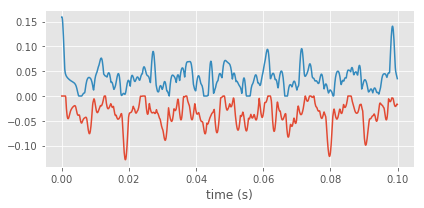

In [6]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
ax.plot(times, u_t.min(axis=(1, 2)),
         times, u_t.max(axis=(1, 2)))
ax.set_xlabel("time (s)")
fig.tight_layout()
plt.show()

The min/max values do not appear to grow, indicating stable integration.

#### 2D Animation
For 2D animation to work in a Jupyter notebook, use

In [6]:
%matplotlib ipympl

If no animations are visible, restart kernel and execute the `%matplotlib ipympl` cell as the very first one in the notebook.

We use `matplotlib.animation` to look at movies of our solution:

In [7]:
import matplotlib.animation as animation

The `update_wave()` function simply re-draws our image for every `frame`.

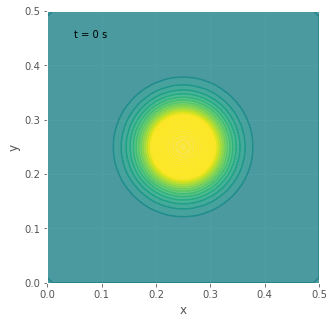

In [8]:
u_limits = 0.5*u_t.min(), 0.5*u_t.max()

fig1 = plt.figure(figsize=(5,5))
ax = fig1.add_subplot(111)
ax.set_aspect(1)

def update_wave(frame, data):
    global ax, Dt, u_limits, X, Y
    ax.clear()
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.contour(X, Y, data[frame], 30, cmap=plt.cm.viridis, norm=plt.Normalize(*u_limits))
    ax.contourf(X, Y, data[frame], 30, cmap=plt.cm.viridis, norm=plt.Normalize(*u_limits), alpha=0.8)
    ax.text(0.1, 0.9, "t = {0:g} s".format(frame*Dt), transform=ax.transAxes)

wave_anim = animation.FuncAnimation(fig1, update_wave, len(u_t), fargs=(u_t, ), 
                                    interval=5, blit=False, repeat_delay=1000)


If you have `ffmpeg` installed then you can export to a MP4 movie file:

In [81]:
wave_anim.save("square_drum_contours.mp4", fps=30, dpi=300)

#### 3D animation



In [9]:
from mpl_toolkits.mplot3d import Axes3D

In [10]:
def plot_wireframe(X, Y, u, limits=None, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
    ax.plot_wireframe(X, Y, u)
    ax.set_xlabel(r"position $x$ (m)")
    ax.set_ylabel(r"position $y$ (m)")
    ax.set_zlabel(r"displacement $u$ (m)")
    ax.set_zlim(limits)
    ax.figure.tight_layout()
    return ax

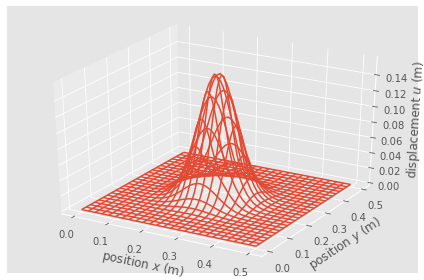

In [11]:
plot_wireframe(X, Y, u_t[0])

<IPython.core.display.Javascript object>


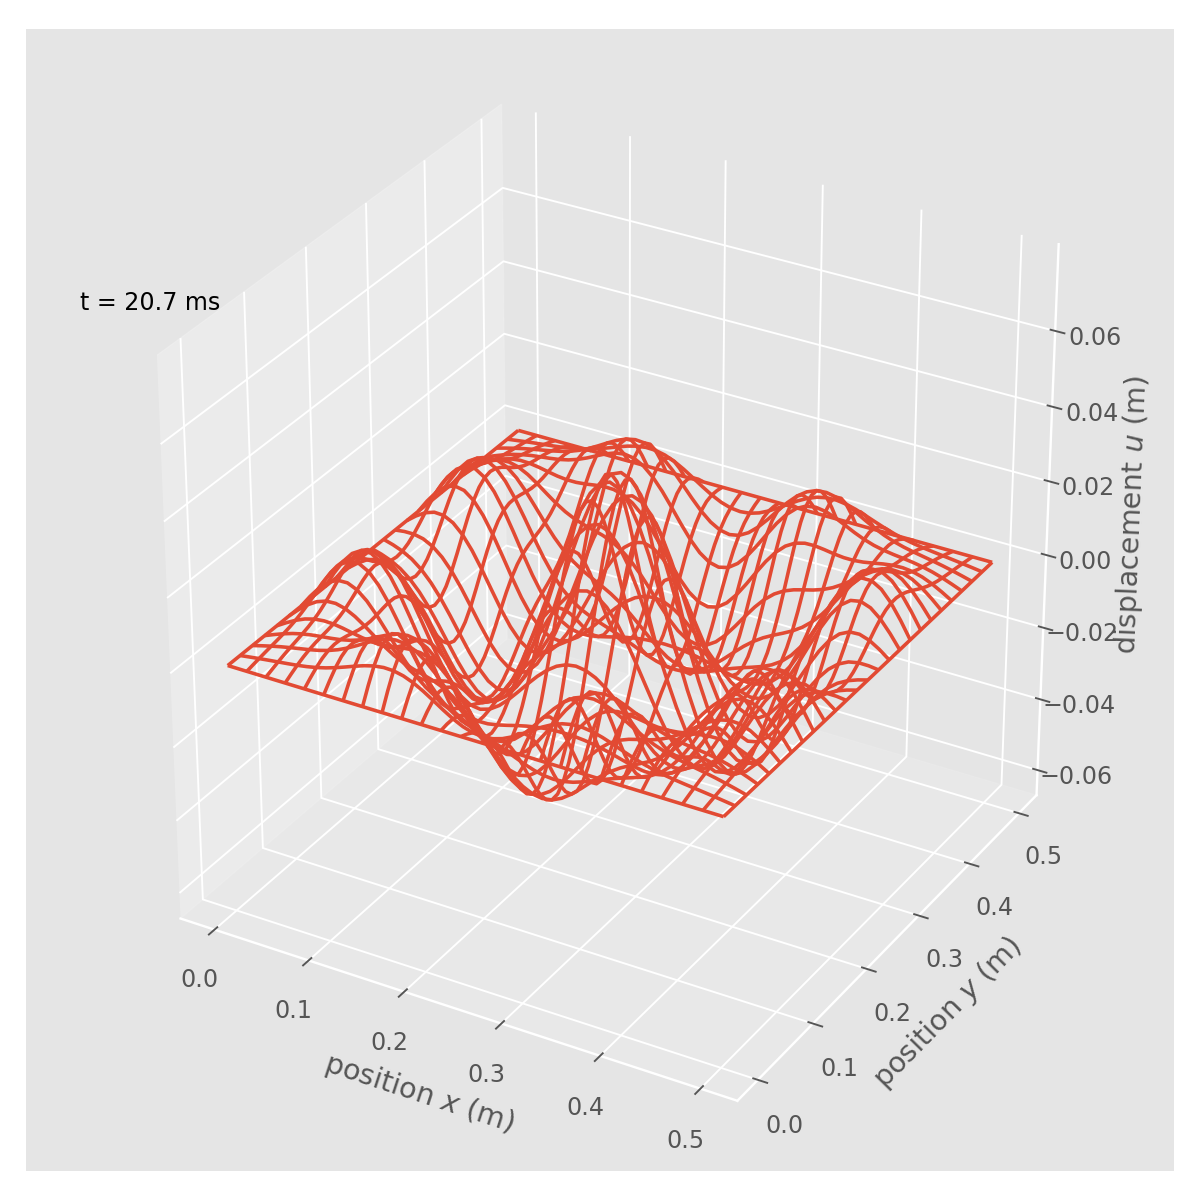

In [116]:
u_limits = 0.5*u_t.min(), 0.5*u_t.max()

fig2 = plt.figure(figsize=(7,7))
ax = fig2.add_subplot(111, projection="3d")
ax.set_aspect(1)

def update_wire(frame, data):
    global ax, u_limits, X, Y
    ax.clear()
    plot_wireframe(X, Y, data[frame], limits=u_limits, ax=ax)
    ax.text(0.1, 0.9, 0.9, "t = {0:3.1f} ms".format(frame*Dt*1000), transform=ax.transAxes)

wire_anim = animation.FuncAnimation(fig2, update_wire, len(u_t), fargs=(u_t,), 
                                    interval=30, blit=False, repeat_delay=1000)


In [208]:
wire_anim.save("square_drum_wire.mp4", fps=30, dpi=300)

#### Making pretty graphics 

We want to us a surface representation where the color indicates the displacement. We also want to show our animation on a [webpage](http://asu-compmethodsphysics-phy494.github.io/ASU-PHY494/2017/04/20/17_PDEs_waves/#leap-frog-algorithm-for-solving-the-wave-equation).

In [12]:
import matplotlib.colors

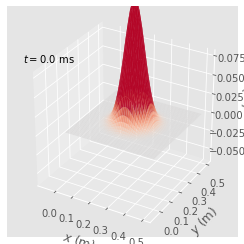

In [13]:
def plot_surface(X, Y, u, limits=None, ax=None, **kwargs):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(X, Y, u, rstride=1, cstride=1, shade=True,
                    cmap=plt.cm.coolwarm, norm=norm, **kwargs)
    ax.set_xlabel(r"$x$ (m)")
    ax.set_ylabel(r"$y$ (m)")
    ax.set_zlabel(r"$u$ (m)")

    # fix scaling see https://stackoverflow.com/a/19933125
    #scaling = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    scaling = np.array([X.min(), X.max(), Y.min(), Y.max(), min(limits), max(limits)])
    ax.auto_scale_xyz(*[[np.min(scaling), np.max(scaling)]]*3)
    
    ax.set_zlim(limits)
    
    ax.figure.tight_layout()
    return ax

u_limits = 0.5*u_t.min(), 0.5*u_t.max()
umax = 0.4*np.max(np.abs(u_limits))
norm = matplotlib.colors.Normalize(vmin=-umax, vmax=umax)

fig3 = plt.figure(figsize=(3.5, 3.5))
ax = fig3.add_subplot(111, projection="3d")
# ax.set_aspect(1)

def update_surface(frame, data):
    global ax, u_limits, X, Y
    ax.clear()
    plot_surface(X, Y, data[frame], limits=u_limits, ax=ax, alpha=0.9)
    ax.text(0.2, 0.9, 0.9, "$t = {0:3.1f}$ ms".format(frame*Dt*1000), transform=ax.transAxes)
    ax.figure.tight_layout()
    
wire_anim = animation.FuncAnimation(fig3, update_surface, len(u_t), fargs=(u_t,), 
                                    interval=30, blit=False, repeat_delay=1000)


The whole video can be incorporated into an html page (uses the HTML5 `<video>` tag). 

In [94]:
tag = wire_anim.to_html5_video()
with open("square_drum_redblue_2d.html", "w") as html:
    html.write(tag)

or exported as a MPEG4 movie (uses `ffmpeg`):

In [93]:
wire_anim.save("square_drum_surface.mp4", fps=30, dpi=300)